# A notebook to fetch Energy Monitor time-series data from thingspeak and run LSTM time-series learning and prediction routine

In [1]:
%matplotlib inline
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
import numpy as np
import math
import warnings
import pandas
from sklearn import linear_model
from matplotlib import pyplot
import datetime
from pandas import DataFrame,concat,Series

## Use Thingspeak API read key to fetch last 8000 datapoints

In [2]:
import thingspeak

channel_id = 257084
read_key    = "UHD7GTZLM9JIHG36"

channel = thingspeak.Channel(id=channel_id,api_key=read_key)

series_json = None
num_result = 8000

try:
    # Get the last 10K power readings
    series_json = channel.get_field(field='field2', options = {'results': num_result})
except:
    raise
    print("connection failed")

In [3]:
import json
data = json.loads(series_json)

In [4]:
x = list()
y = list()
for entry in data['feeds']:
    y.append(-float(entry[u'field2']))
    x.append(datetime.datetime.strptime(entry[u'created_at'],'%Y-%m-%dT%H:%M:%SZ'))
power = np.array(y)
times = np.array(x)

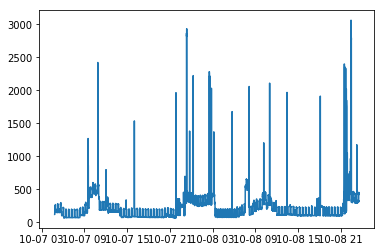

In [5]:
pyplot.figure()
pyplot.plot(times,power)

## Use Keras LSTM to fit time-series
Reference: http://machinelearningmastery.com/time-series-forecasting-long-short-term-memory-network-python/

In [6]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, GRU, Dropout, Activation

Using TensorFlow backend.


In [7]:
# frame a sequence as a supervised learning problem
def timeseries_to_supervised(values,times, lag=1):
    df = DataFrame(values,index=times)
    columns = [df.shift(i) for i in range(1, lag+1)]
    columns.append(df)
    df = concat(columns, axis=1)
    df.fillna(0, inplace=True)
    return df

### Various pre-processing steps to formulate the time series as an LSTM forecast problem

In [8]:
# Create a differential and interval 1
def difference(dataset, interval=1):
    diff = list()
    for i in range(interval, len(dataset)):
        value = dataset[i] - dataset[i - interval]
        diff.append(value)
    return Series(diff)

# invert differenced value
def inverse_difference(history, yhat, interval=1):
    return yhat + history[-interval]
 
# scale train and test data to [-1, 1]
def scale(train, test):
    # fit scaler
    scaler = MinMaxScaler(feature_range=(-1, 1))
    scaler = scaler.fit(train)
    # transform train
    train = train.reshape(train.shape[0], train.shape[1])
    train_scaled = scaler.transform(train)
    # transform test
    test = test.reshape(test.shape[0], test.shape[1])
    test_scaled = scaler.transform(test)
    return scaler, train_scaled, test_scaled
 
# inverse scaling for a forecasted value
def invert_scale(scaler, X, value):
    new_row = [x for x in X] + [value]
    array = np.array(new_row)
    array = array.reshape(1, len(array))
    inverted = scaler.inverse_transform(array)
    return inverted[0, -1]

### Fit and Forecast routines

In [9]:
# fit an LSTM network to training data
def fit_lstm(train, batch_size, nb_epoch, neurons):
    X, y = train[:, 0:-1], train[:, -1]
    X = X.reshape(X.shape[0], 1, X.shape[1])
    model = Sequential()
    model.add(LSTM(neurons, batch_input_shape=(batch_size, X.shape[1], X.shape[2]), stateful=True))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    for i in range(nb_epoch):
        model.fit(X, y, epochs=1, batch_size=batch_size, verbose=0, shuffle=False)
        model.reset_states()
    return model
 
# make a one-step forecast
def forecast_lstm(model, batch_size, X):
    X = X.reshape(1, 1, len(X))
    yhat = model.predict(X, batch_size=batch_size)
    return yhat[0,0]

### Apply pre-processing steps to Power time series

In [10]:
diff_values = difference(power, 1)

In [11]:
# transform data to be supervised learning
supervised = timeseries_to_supervised(power,times, 1)
supervised_values = supervised.values

In [12]:
# split data into train and test-sets
train, test = supervised_values[0:-int(num_result/4)], supervised_values[-int(num_result/4):]

In [13]:
# transform the scale of the data
scaler, train_scaled, test_scaled = scale(train, test)

### Fit the LSTM model

In [14]:
# fit the model
lstm_model = fit_lstm(train_scaled, 1, 3000, 4)
# forecast the entire training dataset to build up state for forecasting
train_reshaped = train_scaled[:, 0].reshape(len(train_scaled), 1, 1)
lstm_model.predict(train_reshaped, batch_size=1)

array([[-1.04741776],
       [-0.740574  ],
       [-0.93054497],
       ..., 
       [-0.96131653],
       [-0.96654099],
       [-0.96626902]], dtype=float32)

## Walk-forward validation on the test data

Test RMSE: 337.392


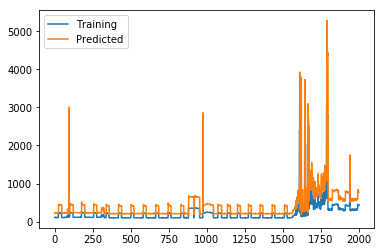

In [15]:
predictions = list()
for i in range(len(test_scaled)):
    # make one-step forecast
    X, y = test_scaled[i, 0:-1], test_scaled[i, -1]
    yhat = forecast_lstm(lstm_model, 1, X)
    # invert scaling
    yhat = invert_scale(scaler, X, yhat)
    # invert differencing
    yhat = inverse_difference(power, yhat, len(test_scaled)+1-i)
    # store forecast
    predictions.append(yhat)
    expected = power[len(train) + i]
    #print('Time=%d, Predicted=%f, Expected=%f' % (i+1, yhat, expected))
 
# report performance
rmse = np.sqrt(mean_squared_error(power[int(-num_result/4):], predictions))
print('Test RMSE: %.3f' % rmse)
# line plot of observed vs predicted
pyplot.plot(power[int(-num_result/4):],label="Training")
pyplot.plot(predictions,label="Predicted")
pyplot.legend()
pyplot.show()

## Pattern fit is descent but we have some scaling issues, fix that with a linear regression

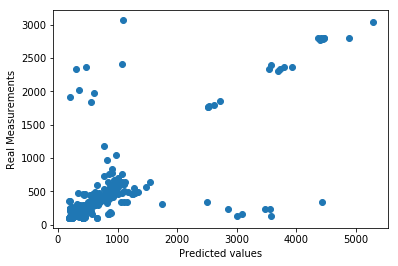

0.509764998604 12.0286781353 0.800488870697 0.0 0.00853877867063


In [25]:
from scipy import stats
real = power[int(-num_result/4):]
slope, intercept, r_value, p_value, std_err = stats.linregress(predictions,real)
pyplot.scatter(predictions,real)
pyplot.ylabel('Real Measurements')
pyplot.xlabel('Predicted values')
pyplot.show()
print(slope, intercept, r_value, p_value, std_err)

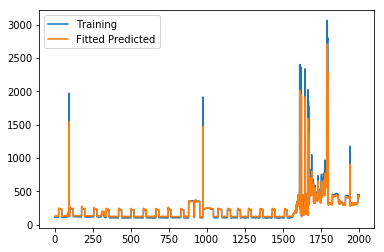

Test RMSE: 169.645


In [37]:
pyplot.plot(real,label="Training")
scaled_prediction = np.array(predictions,dtype=np.float64)*slope+intercept
pyplot.plot(scaled_prediction,label="Fitted Predicted")
pyplot.legend()
pyplot.show()
# report performance
rmse = np.sqrt(mean_squared_error(real, scaled_prediction))
print('Test RMSE: %.3f' % rmse)